In [117]:
import numpy as np  # linear algebra

from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.color import rgb2lab
from skimage.color import lab2rgb
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D, InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from IPython import display

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import datetime

In [58]:
# ! pip install -q kaggle

# Need kaggle.json
We Need a `kaggle.json` input that you can get from your kaggle account.
For mor information on how to get it refer: [Easiest way to download kaggle data in Google Colab](https://www.kaggle.com/general/74235)


In [59]:
# from google.colab import files
# files.upload()

In [60]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [61]:
# ! kaggle datasets download -d theblackmamba31/landscape-image-colorization
# ! echo "A" | unzip landscape-image-colorization.zip > /dev/null
# ! ls

In [62]:
start = time.time()

In [91]:
ROOT_DIR = 'landscape Images/'
GRAY_DIR = ROOT_DIR + 'gray/'
COLOR_DIR = ROOT_DIR + 'color/'
TEST_DIR = ROOT_DIR + 'test/'
RESULTS_DIR = ROOT_DIR + 'results/'
LIMIT = 7128
NORMALIZATION_FACTOR = 255.0
STEP_EPOCHS = 10
EPOCHS = 3

# The range of files in the Colored images directory

In [64]:
file_names = os.listdir(COLOR_DIR)
file_names.sort(key=lambda x: int(x.split('.')[0]))
file_names = file_names[:LIMIT]
print('Range: ', file_names[0], file_names[-1], len(file_names))

Range:  0.jpg 7127.jpg 7128


# Sample images:

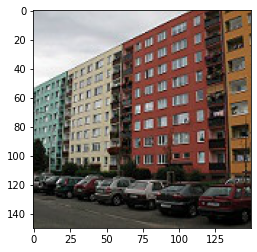

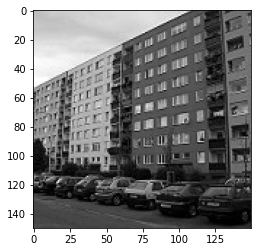

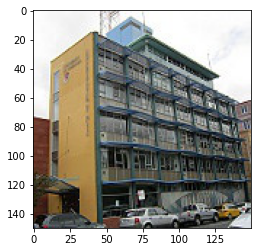

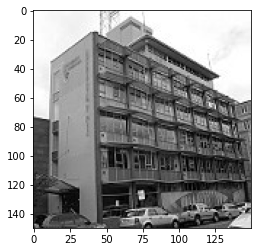

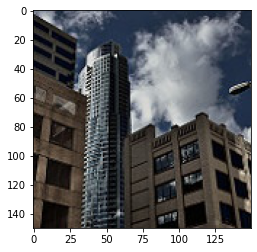

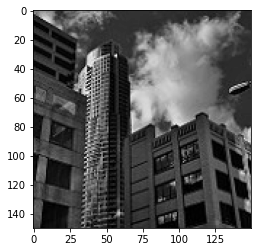

In [65]:
for fileName in file_names[-3:]:
    color_img = mpimg.imread(COLOR_DIR + fileName)
    gray_img = mpimg.imread(GRAY_DIR + fileName)
    color_imgplot = plt.imshow(color_img)
    plt.show()
    gray_imgplot = plt.imshow(gray_img, cmap='gray', vmin=0, vmax=255)
    plt.show()

# Total number of colored images

In [66]:
tot_color_images = len(os.listdir(COLOR_DIR)[:LIMIT])
tot_color_images

7128

# Total number of gray scaled images

In [67]:
tot_gray_images = len(os.listdir(GRAY_DIR)[:LIMIT])
tot_gray_images

7128

# We will now need to resize and normalize all the input images to a preferable normal

In [68]:
height, width, channel = 256, 256, 3
input_shape = (height, width, 1)
images_name = next(os.walk(COLOR_DIR))[2]
images_name = images_name[:LIMIT]

In [69]:
all_colored_images_normalized = np.zeros((len(images_name), height, width, channel), dtype=np.uint8)
all_gray_images_normalized = np.zeros((len(images_name), height, width), dtype=np.uint8)
for image_index, image_name in tqdm(enumerate(images_name)):
    # Adding image names with base directory to get full path for every images
    colored_image_path = COLOR_DIR + image_name + ''
    colored_image_info = imread(colored_image_path)

    gray_image_path = GRAY_DIR + image_name + ''
    gray_image_info = imread(gray_image_path)

    # Resizing every image to 256*256 as declared previously
    colored_image_info = resize(colored_image_info, (height, width), mode='constant', preserve_range=True)
    all_colored_images_normalized[image_index] = colored_image_info

    gray_image_info = resize(gray_image_info, (height, width), mode='constant', preserve_range=True)
    all_gray_images_normalized[image_index] = gray_image_info

# Normalizing values between 0 to 1 by diving
all_colored_images_normalized = all_colored_images_normalized.astype('float32') / NORMALIZATION_FACTOR
all_gray_images_normalized = all_gray_images_normalized.astype('float32') / NORMALIZATION_FACTOR

7128it [00:31, 228.51it/s]


In [70]:
train_output, test_output = train_test_split(all_colored_images_normalized, test_size=0.2, random_state=25)
train_input, test_input = train_test_split(all_gray_images_normalized, test_size=0.2, random_state=25)

In [71]:
len(train_output)

5702

In [72]:
len(train_input)

5702

In [73]:
len(test_output)

1426

In [74]:
len(test_input)

1426

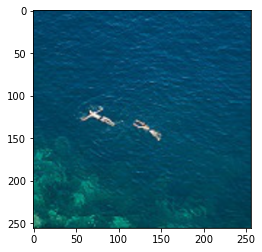

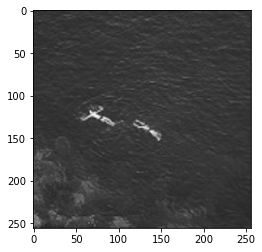

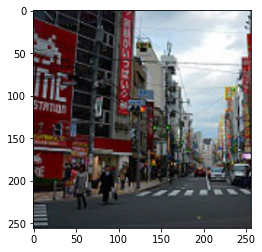

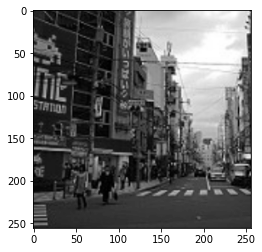

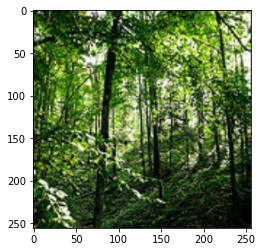

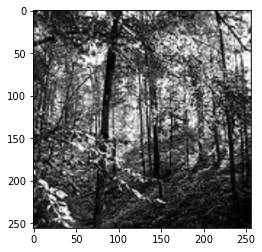

In [75]:
for index in range(3):
    color_img_plt = plt.imshow(train_output[index])
    plt.show()
    gray_img_plt = plt.imshow(train_input[index], cmap='gray', vmin=0, vmax=1)
    plt.show()

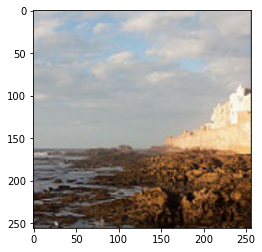

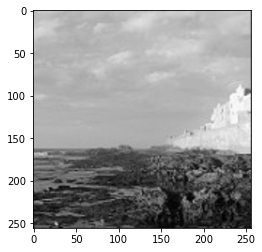

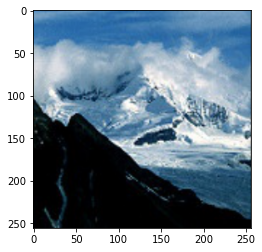

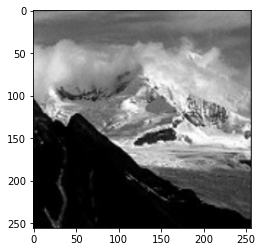

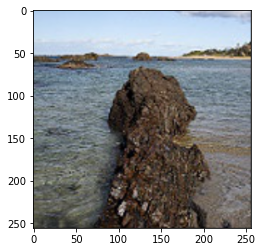

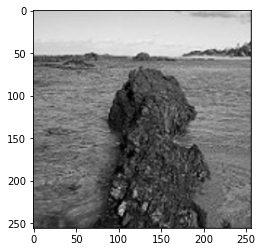

In [76]:
for index in range(3):
    color_img_plt = plt.imshow(test_output[index])
    plt.show()
    gray_img_plt = plt.imshow(test_input[index], cmap='gray', vmin=0, vmax=1)
    plt.show()

In [77]:
end = time.time()
print(f'Execution time: {str(datetime.timedelta(seconds=(end - start)))} (HH:MM:SS)')

Execution time: 0:01:46.653020 (HH:MM:SS)


# Creating the model
We first thought of creating a model that accepts the gray scale (256, 256, 1) image and spit out 3 layers of RGB matrix
separately, this was a tedious task and the results gave us images with only one of the colors as dominant.

![Sample image generating RGB matrices Separately](landscape Images/results_1st/img_0.png)

As you see from above that the generated output has a dominance in blue color.

To ease up on this prediction we reduce the output to 2 matrices a* and b*, Which are red, green and blue, yellow
matrices which are used in the LAB (L* a* b*) color space

![Lab Color Space](lab_color_space.png)

In [ ]:
display.Image("./img_0.png")

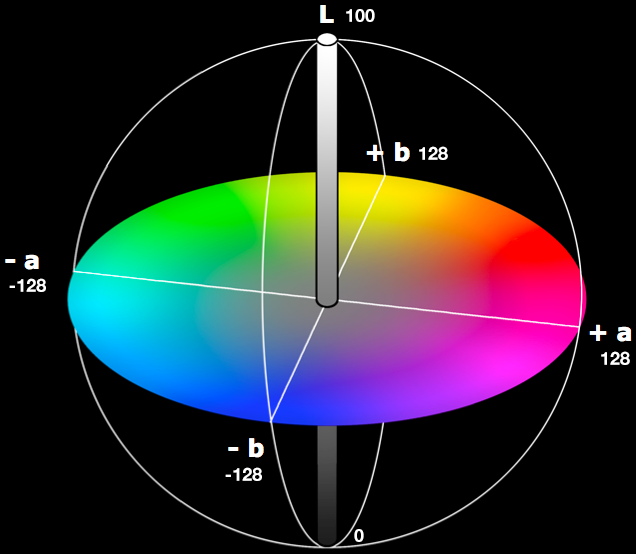

In [102]:
display.Image("./lab_color_space.png")

In [78]:
#Design the neural network (Cycle-Consistent Adversarial Networks)
model = Sequential()

# Input Layer Gray scale image
model.add(InputLayer(input_shape=(256, 256, 1)))

# Encoding the input
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

# Decode
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

In [79]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 512)      

In [80]:
# Compile the model
model.compile(optimizer='rmsprop', loss='mse')

In [81]:
# Image Augmentation
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True)

In [82]:
# Generate training data
batch_size = 50


def image_a_b_gen(batch_size):
    for batch in datagen.flow(train_output, batch_size=batch_size):
        # gray_rgb = gray2rgb(rgb2gray(batch))
        lab_batch = rgb2lab(batch)

        # The gray layer from the lab colour space batch
        train_input_batch = lab_batch[:, :, :, 0]
        train_input_batch = train_input_batch.reshape(train_input_batch.shape + (1,))

        # The (green, red) and (blue, yellow) layers
        train_output_batch = lab_batch[:, :, :, 1:] / 128
        yield train_input_batch, train_output_batch

In [87]:
# Train model
model.fit_generator(image_a_b_gen(batch_size), steps_per_epoch=STEP_EPOCHS, epochs=EPOCHS)
# (50, 256, 256, 3)

Epoch 1/10
1/1 [==============================] - 24s 24s/step - loss: 0.9923
Epoch 2/10
1/1 [==============================] - 17s 17s/step - loss: 0.9905
Epoch 3/10
1/1 [==============================] - 17s 17s/step - loss: 1.0095
Epoch 4/10
1/1 [==============================] - 23s 23s/step - loss: 0.9756
Epoch 5/10
1/1 [==============================] - 22s 22s/step - loss: 0.9735
Epoch 6/10
1/1 [==============================] - 24s 24s/step - loss: 0.1341
Epoch 7/10
1/1 [==============================] - 21s 21s/step - loss: 0.4531
Epoch 8/10
1/1 [==============================] - 20s 20s/step

In [88]:
# Lab matrix dimensions:
# [ n, h, w, l]
# n -> number of images
# h -> height of each image in the array
# w -> width
# l -> layer
# 3 layers
# l = 0 -> grayscale
# l = 1 -> red, green intensity
# l = 2 -> blue, yellow intensity
# Validation for model
validation_input_gray_lab = rgb2lab(gray2rgb(test_input))[:, :, :, 0]
validation_input_gray_lab = validation_input_gray_lab.reshape(validation_input_gray_lab.shape + (1,))
validation_output_rgb_lab = rgb2lab(test_output)[:, :, :, 1:]
validation_output_rgb_lab = validation_output_rgb_lab / 128
print(model.evaluate(validation_input_gray_lab, validation_output_rgb_lab, batch_size=batch_size))

29/29 [==============================] - 97s 3s/step - loss: 0.0135

In [128]:
# Load black and white images
unknown_test_sample_gray = []
for filename in os.listdir(TEST_DIR):
    gray_scale_test_image = img_to_array(load_img(TEST_DIR + filename))
    gray_scale_test_image = resize(gray_scale_test_image, (height, width), mode='constant', preserve_range=True)
    unknown_test_sample_gray.append(gray_scale_test_image)
unknown_test_sample_gray_cpy = unknown_test_sample_gray

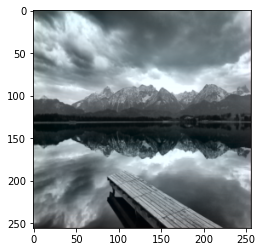

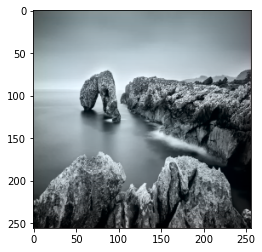

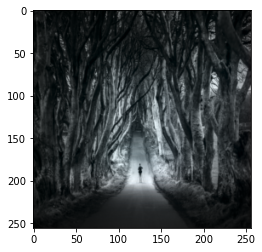

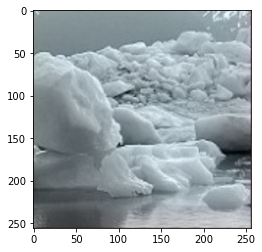

In [129]:
unknown_test_sample_gray = np.array(unknown_test_sample_gray, dtype=float)
unknown_test_sample_gray = rgb2lab(1.0 / NORMALIZATION_FACTOR * unknown_test_sample_gray)[:, :, :, 0]
unknown_test_sample_gray = unknown_test_sample_gray.reshape(unknown_test_sample_gray.shape + (1,))

# Test model
predictions = model.predict(unknown_test_sample_gray)
predictions = predictions * 128

# Output colorization
for prediction in range(len(predictions)):
    prediction_lab = np.zeros((256, 256, 3))
    prediction_lab[:, :, 0] = unknown_test_sample_gray[prediction][:, :, 0]
    prediction_lab[:, :, 1:] = predictions[prediction]
    prediction_rgb = lab2rgb(prediction_lab)
    color_img_plt = plt.imshow(prediction_rgb)
    plt.show()
    plt.imsave(RESULTS_DIR + "img_" + str(prediction) + ".png", prediction_rgb)

# Setbacks
- Color dominance.
- RAM limitations.
- Mismatch in Dimensions while architecting and training the model.

# Ongoing work
- Improving accuracy.
    - Bright Colors.
- Resolution.
- Benchmarking Performance with the standard models.

# References
[To download data from Kaggle into a Colab Notebook Kaggle](https://www.kaggle.com/general/74235)

[Image Colorizer by SHUVRO MAC](https://www.kaggle.com/shuvromac/final-version-colorization)